### "Pipelines Version", for step-by-step code & more insights, please refer to "Accident_Pred_02" notebook.

## 1) Tools and Dataset

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.neural_network import MLPRegressor

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense

from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the first five columns

raw_df = pd.read_csv('../../dataset/dataset.csv', usecols=[0,1,2,3,4])
df = raw_df.copy()

## 2) EDA and Data Preparation

In [3]:
# data preparation pipeline

def prep_pipeline(df):
    
    # if raw_df, we need to keep all the records (2000:2022), filling the NaNs by 0 in WERT column.
    if df is not raw_df:
        df= df[df.JAHR < 2021].reset_index().drop(columns=['index'])
    if df is raw_df:
        df["WERT"]= df["WERT"].fillna(0)

    # dropping Summe records, useless; ML-wise.
    df= df[df.MONAT != "Summe"].reset_index().drop(columns=['index'])
    
    # casting the MONAT column to int dtype.
    for i in range(len(df["MONAT"])):
        df["MONAT"][i]= df["MONAT"][i][-2:]
    df= df.astype({'MONAT': 'int64'})
    
    print(df.info(), df.head())
    
    return df

In [4]:
# for predictions

prep_raw_df= prep_pipeline(raw_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MONATSZAHL   1932 non-null   object 
 1   AUSPRAEGUNG  1932 non-null   object 
 2   JAHR         1932 non-null   int64  
 3   MONAT        1932 non-null   int64  
 4   WERT         1932 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 75.6+ KB
None        MONATSZAHL AUSPRAEGUNG  JAHR  MONAT  WERT
0  Alkoholunfälle   insgesamt  2022      1   0.0
1  Alkoholunfälle   insgesamt  2022      2   0.0
2  Alkoholunfälle   insgesamt  2022      3   0.0
3  Alkoholunfälle   insgesamt  2022      4   0.0
4  Alkoholunfälle   insgesamt  2022      5   0.0


In [5]:
# for training

df= prep_raw_df[prep_raw_df["JAHR"] != 2021][prep_raw_df["JAHR"] != 2022].reset_index().drop(columns=['index'])

## 3) Mission 1
#### 3.1) Visualising historically the number of accidents per category
#### 3.2) Creating the AI model

### 3.1) Number of Accidents per Category 

In [6]:
# Number of total accidents per each specific month, along 2000:2020, in order to find the max/min month during the year.

rate_per_month= []
for i in df.MONAT.unique():
    temp= df[df.MONAT== i]["WERT"].sum()
    print(f"Number of total accidents in month ({i})","throughout the period 2000:2020 is:", temp)
    rate_per_month.append(temp)
    
print()
print("Maximum month is: %d >" % df.MONAT[rate_per_month.index(max(rate_per_month))], max(rate_per_month), "accidents")
print("Minimum month is: %d >" % df.MONAT[rate_per_month.index(min(rate_per_month))], min(rate_per_month), "accidents")

Number of total accidents in month (1) throughout the period 2000:2020 is: 94974.0
Number of total accidents in month (2) throughout the period 2000:2020 is: 95847.0
Number of total accidents in month (3) throughout the period 2000:2020 is: 110494.0
Number of total accidents in month (4) throughout the period 2000:2020 is: 111716.0
Number of total accidents in month (5) throughout the period 2000:2020 is: 122488.0
Number of total accidents in month (6) throughout the period 2000:2020 is: 120575.0
Number of total accidents in month (7) throughout the period 2000:2020 is: 138930.0
Number of total accidents in month (8) throughout the period 2000:2020 is: 106428.0
Number of total accidents in month (9) throughout the period 2000:2020 is: 124749.0
Number of total accidents in month (10) throughout the period 2000:2020 is: 128404.0
Number of total accidents in month (11) throughout the period 2000:2020 is: 113899.0
Number of total accidents in month (12) throughout the period 2000:2020 is: 

In [7]:
# Number of accidents along 2000:2020, per year, per category.

# The output is a list of lists, with dimension: 3 categories x 21 years

print(df.MONATSZAHL.unique())
print()

annual_per_cat= []
for i in df.MONATSZAHL.unique():
    per_cat_per_yr= []
    for j in df.JAHR.unique():
        sum_of_acc_per_cat_per_yr= df[df.MONATSZAHL == i][df.JAHR == j]["WERT"].sum()
        per_cat_per_yr.append(sum_of_acc_per_cat_per_yr)
    annual_per_cat.append(per_cat_per_yr)
print(annual_per_cat)

['Alkoholunfälle' 'Fluchtunfälle' 'Verkehrsunfälle']

[[680.0, 661.0, 580.0, 585.0, 445.0, 636.0, 549.0, 530.0, 663.0, 595.0, 603.0, 643.0, 722.0, 841.0, 885.0, 881.0, 963.0, 1049.0, 1182.0, 1239.0, 1310.0], [10489.0, 12314.0, 12203.0, 11814.0, 11727.0, 11867.0, 11403.0, 11707.0, 11685.0, 10756.0, 10355.0, 9726.0, 9834.0, 9603.0, 9134.0, 11562.0, 11089.0, 10173.0, 11279.0, 12083.0, 12125.0], [49056.0, 57562.0, 58406.0, 56574.0, 58535.0, 58589.0, 58995.0, 58896.0, 56620.0, 52857.0, 46946.0, 46391.0, 47151.0, 48061.0, 48888.0, 52599.0, 51497.0, 50052.0, 53254.0, 59113.0, 57224.0]]


In [8]:
# Number of accidents along 2000:2020, per month, per category.

# The output is a list of lists of lists, with dimension: 3 categories x 21 years x 12 months

monthly_per_cat= []
for i in df.MONATSZAHL.unique():   # in this order: ['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle']
    
    per_cat_per_yr= []
    for j in df.JAHR.unique():
        
        per_cat_per_month= []
        for k in df.MONAT.unique():
            sum_of_acc_per_cat_per_month= df[df.MONATSZAHL == i][df.JAHR == j][df.MONAT == k]["WERT"].sum()
            per_cat_per_month.append(sum_of_acc_per_cat_per_month)
            
        per_cat_per_yr.append(per_cat_per_month)  
        
    monthly_per_cat.append(per_cat_per_yr)
    
print(monthly_per_cat)

[[[39.0, 59.0, 40.0, 41.0, 66.0, 79.0, 101.0, 75.0, 70.0, 54.0, 34.0, 22.0], [29.0, 35.0, 56.0, 54.0, 60.0, 64.0, 82.0, 54.0, 67.0, 65.0, 48.0, 47.0], [30.0, 37.0, 44.0, 33.0, 57.0, 53.0, 80.0, 58.0, 58.0, 59.0, 44.0, 27.0], [23.0, 26.0, 51.0, 36.0, 45.0, 68.0, 70.0, 44.0, 69.0, 48.0, 46.0, 59.0], [27.0, 13.0, 26.0, 35.0, 42.0, 49.0, 58.0, 46.0, 51.0, 41.0, 27.0, 30.0], [43.0, 26.0, 32.0, 52.0, 80.0, 58.0, 86.0, 78.0, 70.0, 37.0, 41.0, 33.0], [25.0, 24.0, 53.0, 50.0, 47.0, 47.0, 56.0, 45.0, 61.0, 57.0, 56.0, 28.0], [19.0, 15.0, 29.0, 33.0, 54.0, 57.0, 66.0, 61.0, 64.0, 43.0, 47.0, 42.0], [32.0, 23.0, 26.0, 56.0, 87.0, 78.0, 86.0, 86.0, 73.0, 38.0, 40.0, 38.0], [41.0, 32.0, 31.0, 70.0, 63.0, 48.0, 66.0, 51.0, 58.0, 36.0, 56.0, 43.0], [26.0, 33.0, 43.0, 58.0, 49.0, 59.0, 77.0, 65.0, 80.0, 40.0, 35.0, 38.0], [30.0, 44.0, 19.0, 76.0, 91.0, 50.0, 71.0, 61.0, 67.0, 50.0, 36.0, 48.0], [40.0, 46.0, 39.0, 35.0, 94.0, 88.0, 76.0, 67.0, 77.0, 64.0, 41.0, 55.0], [49.0, 47.0, 52.0, 76.0, 102.0, 78.

In [9]:
# confirming the "monthly_per_cat" list of lists of lists has the dimension 3 x 21 x 12

print("Categories: ", len(monthly_per_cat))
print("Number of years: ", len(monthly_per_cat[0]))
print("Number of months/year: ", len(monthly_per_cat[0][0]))

Categories:  3
Number of years:  21
Number of months/year:  12


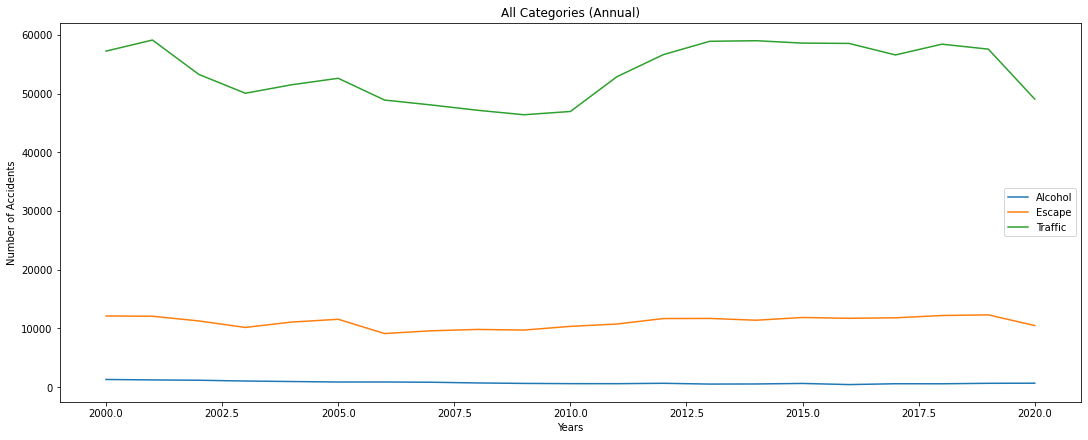

In [10]:
# Annual: Alcohol, Escape, Traffic (respectively)

fig, ax = plt.subplots(figsize=(15, 6), layout='constrained')
ax.plot(df["JAHR"].unique(), annual_per_cat[0], label='Alcohol')
ax.plot(df["JAHR"].unique(), annual_per_cat[1], label='Escape')
ax.plot(df["JAHR"].unique(), annual_per_cat[2], label='Traffic')
ax.set_title("All Categories (Annual)")
ax.set_xlabel('Years')
ax.set_ylabel('Number of Accidents')
ax.legend()
fig.show()

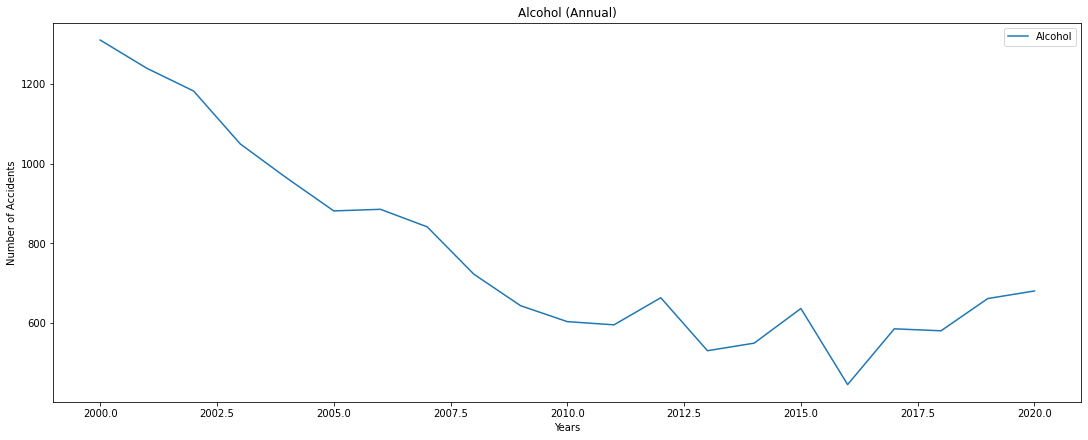

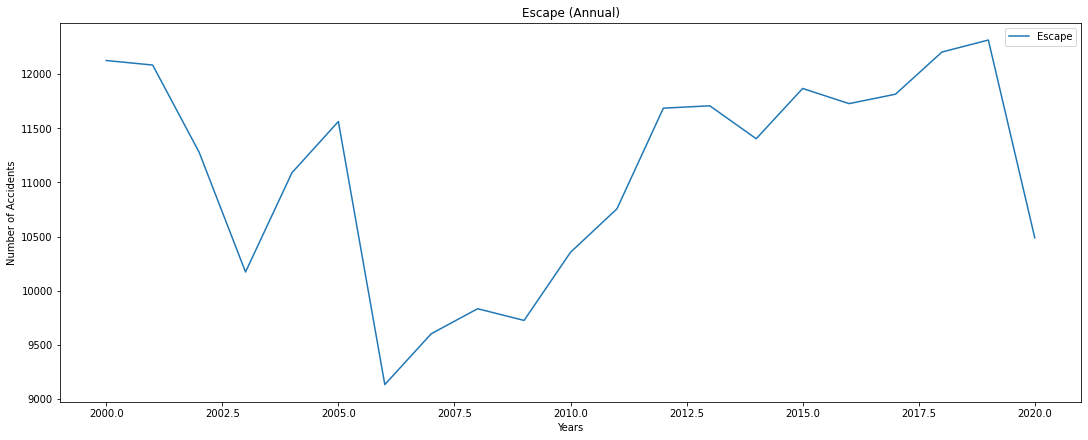

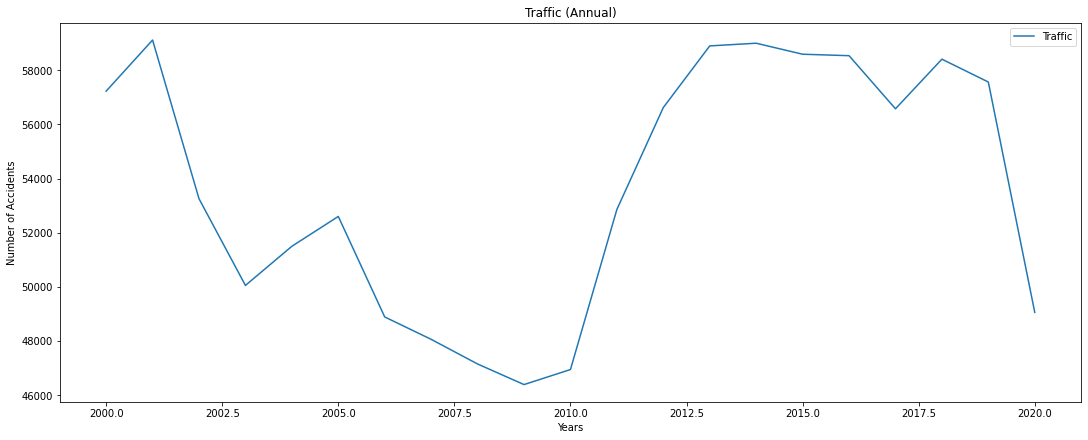

In [11]:
# Annual (separately, more clear):

# Alcohol
fig, ax = plt.subplots(figsize=(15, 6), layout='constrained')
ax.plot(df["JAHR"].unique(), annual_per_cat[0], label='Alcohol')
ax.set_title("Alcohol (Annual)")
ax.set_xlabel('Years')
ax.set_ylabel('Number of Accidents')
ax.legend()
fig.show()

# Escape
fig, ax = plt.subplots(figsize=(15, 6), layout='constrained')
ax.plot(df["JAHR"].unique(), annual_per_cat[1], label='Escape')
ax.set_title("Escape (Annual)")
ax.set_xlabel('Years')
ax.set_ylabel('Number of Accidents')
ax.legend()
fig.show()

# Traffic
fig, ax = plt.subplots(figsize=(15, 6), layout='constrained')
ax.plot(df["JAHR"].unique(), annual_per_cat[2], label='Traffic')
ax.set_title("Traffic (Annual)")
ax.set_xlabel('Years')
ax.set_ylabel('Number of Accidents')
ax.legend()
fig.show()

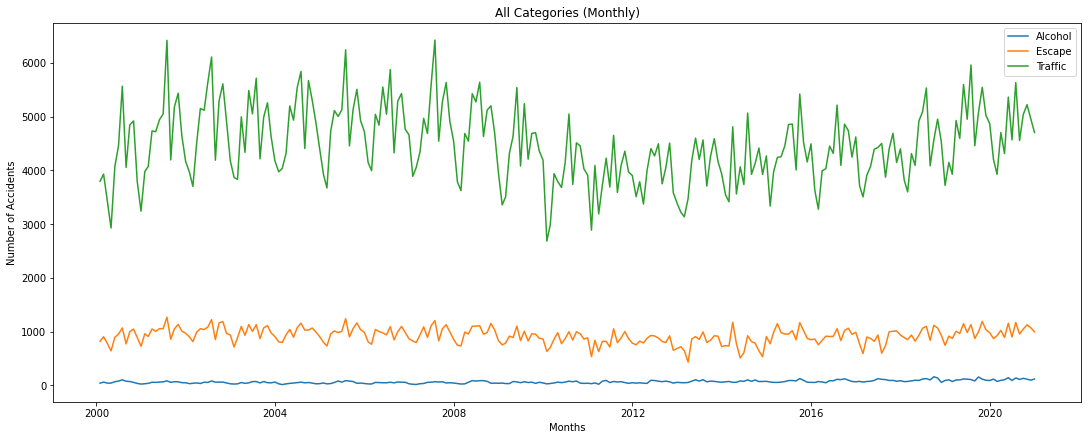

In [12]:
# Monthly: Alcohol, Escape, Traffic (respectively)

fig, ax = plt.subplots(figsize=(15, 6), layout='constrained')
ax.plot(pd.date_range(start='1/2000', periods=252, freq='M'), np.array(monthly_per_cat[0]).reshape(252,1), label='Alcohol')
ax.plot(pd.date_range(start='1/2000', periods=252, freq='M'), np.array(monthly_per_cat[1]).reshape(252,1), label='Escape')
ax.plot(pd.date_range(start='1/2000', periods=252, freq='M'), np.array(monthly_per_cat[2]).reshape(252,1), label='Traffic')
ax.set_title("All Categories (Monthly)")
ax.set_xlabel('Months')
ax.set_ylabel('Number of Accidents')
ax.legend()
fig.show()

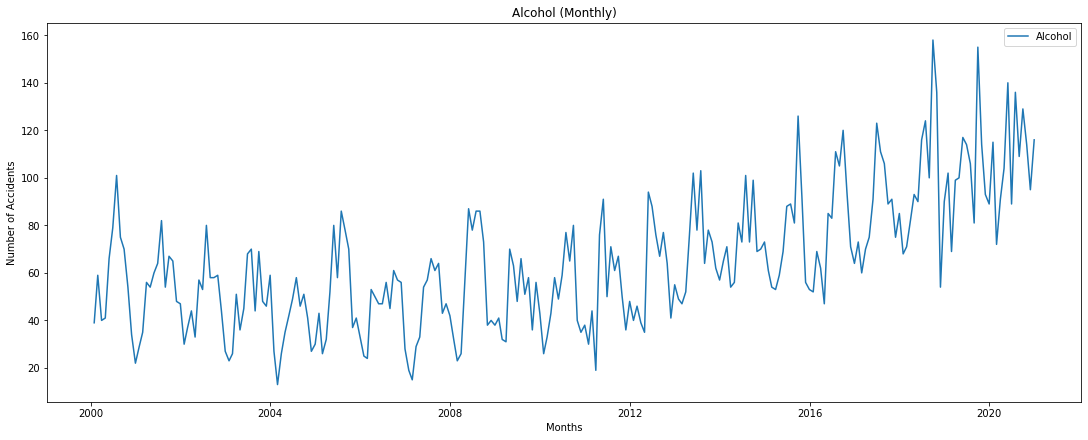

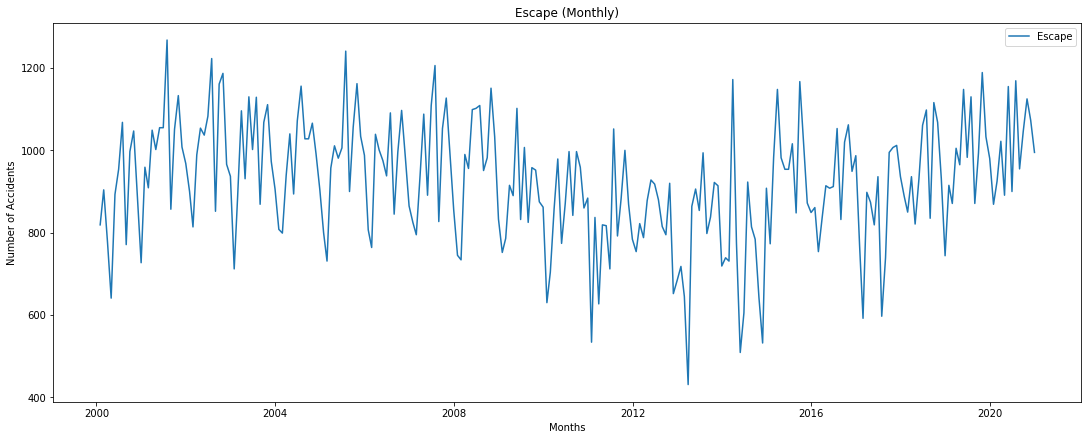

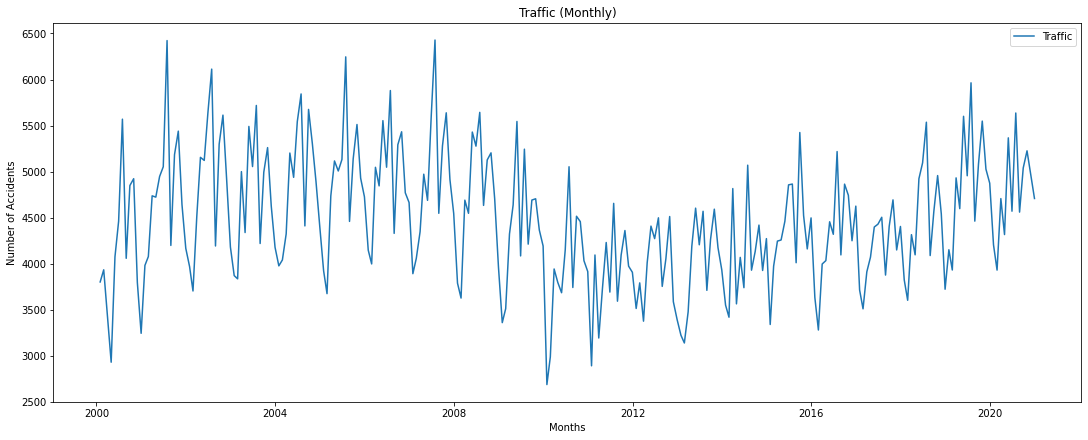

In [13]:
# Monthly (separately, more clear):

# Alcohol
fig, ax = plt.subplots(figsize=(15, 6), layout='constrained')
ax.plot(pd.date_range(start='1/1/2000', periods=252, freq='M'), np.array(monthly_per_cat[0]).reshape(252,1), label='Alcohol')
ax.set_title("Alcohol (Monthly)")
ax.set_xlabel('Months')
ax.set_ylabel('Number of Accidents')
ax.legend()
fig.show()

# Escape
fig, ax = plt.subplots(figsize=(15, 6), layout='constrained')
ax.plot(pd.date_range(start='1/1/2000', periods=252, freq='M'), np.array(monthly_per_cat[1]).reshape(252,1), label='Escape')
ax.set_title("Escape (Monthly)")
ax.set_xlabel('Months')
ax.set_ylabel('Number of Accidents')
ax.legend()
fig.show()

# Traffic
fig, ax = plt.subplots(figsize=(15, 6), layout='constrained')
ax.plot(pd.date_range(start='1/1/2000', periods=252, freq='M'), np.array(monthly_per_cat[2]).reshape(252,1), label='Traffic')
ax.set_title("Traffic (Monthly)")
ax.set_xlabel('Months')
ax.set_ylabel('Number of Accidents')
ax.legend()
fig.show()

### 3.2) AI Model

### 3.2.1) Data Preprocessing

In [14]:
def prepro_pipeline(df):
    
    #splitting the features from then label
    x= df.drop("WERT", axis=1)
    y= df["WERT"]

    # one-hot encoding for the categorigal nominal features
    dummies = pd.get_dummies(x[["MONATSZAHL", "AUSPRAEGUNG"]]).sort_index()
    x = pd.concat([dummies, x], axis=1)
    x = x.drop(["MONATSZAHL", "AUSPRAEGUNG"], axis=1)
    
    # Normalization using MinMaxScaler (more appropiate in this case than StandardScaler, since the dataset has outliers)
    x[:] = MinMaxScaler().fit_transform(x)

    return x, y

In [15]:
# train and validation split

x, y= prepro_pipeline(df)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.15, random_state=42)

### 3.2.1) Prediction Models

In [16]:
def predict_and_compare(records, model):
    
    # for such cases when the slice of rows (records) starting with index != 0
    records= records.reset_index().drop(columns=['index'])
    
    norm_recs= []
    
    for _index , record in records.iterrows():

        norm_rec= []
        
        # one-hot encoding, and
        # custom implementation of the MinMax Scaling (normalization), instead of using the sklearn's. ####(for fun)####
        if record[0] == "Alkoholunfälle":
            norm_rec.extend([1,0,0])
        elif record[0] == "Fluchtunfälle":
            norm_rec.extend([0,1,0])
        elif record[0] == "Verkehrsunfälle":
            norm_rec.extend([0,0,1])

        if record[1] == "Verletzte und Getötete":
            norm_rec.extend([1,0,0])
        elif record[1] == "insgesamt":
            norm_rec.extend([0,1,0])
        elif record[1] == "mit Personenschäden":
            norm_rec.extend([0,0,1])

        # Normalization = (x - xmin) / (xmax - xmin)
        norm_rec.extend([(record[2]-2000)/20, (record[3]-1)/11])
    
        norm_recs.append(norm_rec)
    
    # printing the original and normalized records
    print("\n Original Records \n", records, "\n\n", "\n Normalized Records \n", pd.DataFrame(norm_recs))
    
    # prediction VS actual
    comparison= pd.concat([pd.DataFrame(model.predict(np.array(norm_recs)).astype(int), columns=["Prediction"]),
                           records["WERT"].rename('Actual', inplace = True).astype(int)],
                          axis=1)
    
    # printing the comparison
    print("\n\n\n", "Prediction VS Actual...")
    return comparison

#### 3.2.1.1) NN MLPRegressor model

In [17]:
# NN MLPRegressor model

MLPreg_model = MLPRegressor(random_state=1, max_iter=1500).fit(x_train, y_train)
print("MLPRegressor's Score: ", MLPreg_model.score(x_valid, y_valid))

MLPRegressor's Score:  0.9752712950634622


In [18]:
# NN MLPRegressor prediction of ( [Alkoholunfälle, insgesamt, 2021, 1]  >>>  [1,0,0, 0,1,0, 1.05, 0] )

int(MLPreg_model.predict([[1,0,0,0,1,0,1.05,0]]))

16

In [19]:
# NN MLPRegressor prediction of validation data

valid_indexes= x_valid.index
print(predict_and_compare(prep_raw_df.loc[valid_indexes], MLPreg_model))



 Original Records 
           MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT    WERT
0    Verkehrsunfälle               insgesamt  2022      4     0.0
1     Alkoholunfälle               insgesamt  2005      9    76.0
2    Verkehrsunfälle  Verletzte und Getötete  2017     10   572.0
3    Verkehrsunfälle     mit Personenschäden  2011      7   532.0
4    Verkehrsunfälle               insgesamt  2006      1  2893.0
..               ...                     ...   ...    ...     ...
260    Fluchtunfälle               insgesamt  2008     11   625.0
261   Alkoholunfälle               insgesamt  2001     10    77.0
262  Verkehrsunfälle     mit Personenschäden  2010      3   291.0
263   Alkoholunfälle               insgesamt  2002      1    44.0
264  Verkehrsunfälle     mit Personenschäden  2006      9   407.0

[265 rows x 5 columns] 

 
 Normalized Records 
      0  1  2  3  4  5     6         7
0    0  0  1  0  1  0  1.10  0.272727
1    1  0  0  0  1  0  0.25  0.727273
2    0  0  1  1  0  0  

#### 3.2.1.2) Sequential model

In [20]:
# sequential model

input_dim = x_train.shape[1]
print(input_dim)

sq_model = Sequential()
sq_model.add(Dense(8, activation='relu', input_dim=input_dim))
sq_model.add(Dense(16, activation='relu'))
sq_model.add(Dense(32, activation='relu'))
sq_model.add(Dense(64, activation='relu'))
sq_model.add(Dense(128, activation='relu'))
sq_model.add(Dense(256, activation='relu'))
sq_model.add(Dense(512, activation='relu'))
sq_model.add(Dense(1024, activation='relu'))
sq_model.add(Dense(2048, activation='relu'))
sq_model.add(Dense(1024, activation='relu'))
sq_model.add(Dense(512, activation='relu'))
sq_model.add(Dense(128, activation='relu'))
sq_model.add(Dense(64, activation='relu'))
sq_model.add(Dense(32, activation='relu'))
sq_model.add(Dense(16, activation='relu'))
sq_model.add(Dense(8, activation='relu'))
sq_model.add(Dense(1))

sq_model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-5))
history = sq_model.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_valid, y_valid))

8
Epoch 1/50
47/47 [==============================] - 7s 115ms/step - loss: 2053111.2500 - val_loss: 1715695.3750
Epoch 2/50
47/47 [==============================] - 5s 102ms/step - loss: 2053012.7500 - val_loss: 1715520.6250
Epoch 3/50
47/47 [==============================] - 5s 103ms/step - loss: 2052501.7500 - val_loss: 1714601.0000
Epoch 4/50
47/47 [==============================] - 5s 100ms/step - loss: 2049784.1250 - val_loss: 1709753.8750
Epoch 5/50
47/47 [==============================] - 5s 102ms/step - loss: 2036792.5000 - val_loss: 1687722.0000
Epoch 6/50
47/47 [==============================] - 5s 99ms/step - loss: 1984287.2500 - val_loss: 1605475.1250
Epoch 7/50
47/47 [==============================] - 5s 96ms/step - loss: 1809589.3750 - val_loss: 1370800.0000
Epoch 8/50
47/47 [==============================] - 5s 100ms/step - loss: 1453985.0000 - val_loss: 1082871.5000
Epoch 9/50
47/47 [==============================] - 5s 98ms/step - loss: 1235514.6250 - val_loss: 103184

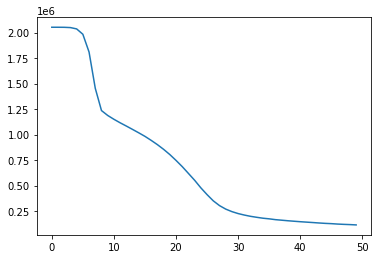

In [21]:
# loss VS epochs

plt.plot(history.history['loss'])

In [22]:
# validation loss

print("Sequential's validation loss: ", sq_model.evaluate(x_valid, y_valid))

9/9 [==============================] - 0s 21ms/step - loss: 98452.3906
Sequential's validation loss:  98452.390625


In [23]:
# Sequential model prediction of ( [Alkoholunfälle, insgesamt, 2021, 1]  >>>  [1,0,0, 0,1,0, 1.05, 0] )

int(sq_model.predict([[1,0,0,0,1,0,1.05,0]]))

1/1 [==============================] - 0s 237ms/step


55

In [24]:
# Sequential model prediction of validation data

valid_indexes= x_valid.index
print(predict_and_compare(prep_raw_df.loc[valid_indexes], sq_model))


 Original Records 
           MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT    WERT
0    Verkehrsunfälle               insgesamt  2022      4     0.0
1     Alkoholunfälle               insgesamt  2005      9    76.0
2    Verkehrsunfälle  Verletzte und Getötete  2017     10   572.0
3    Verkehrsunfälle     mit Personenschäden  2011      7   532.0
4    Verkehrsunfälle               insgesamt  2006      1  2893.0
..               ...                     ...   ...    ...     ...
260    Fluchtunfälle               insgesamt  2008     11   625.0
261   Alkoholunfälle               insgesamt  2001     10    77.0
262  Verkehrsunfälle     mit Personenschäden  2010      3   291.0
263   Alkoholunfälle               insgesamt  2002      1    44.0
264  Verkehrsunfälle     mit Personenschäden  2006      9   407.0

[265 rows x 5 columns] 

 
 Normalized Records 
      0  1  2  3  4  5     6         7
0    0  0  1  0  1  0  1.10  0.272727
1    1  0  0  0  1  0  0.25  0.727273
2    0  0  1  1  0  0  

In [25]:
# saving the sq_model

sq_model.save("AccidentPrediction_SequentialModel.h5")

#### 3.2.1.3) K_Neighbour Regression model

In [26]:
# K Neighbour Regressor model

k_neigh = KNeighborsRegressor(n_neighbors=25, weights='uniform', leaf_size=30, algorithm='brute').fit(x, y)

In [27]:
# parameter tuning

from scipy.stats import randint, expon

print('Tuning hyperparameters...')

parameters = {'n_neighbors': randint(1, 50, 2), 'weights': ['uniform', 'distance'], 'leaf_size': randint(1,70, 5),
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

search_result = RandomizedSearchCV(estimator=k_neigh, param_distributions=parameters, n_jobs=-1).fit(x_train, y_train)
kN_model = search_result.best_estimator_

print({param: kN_model.get_params()[param] for param in parameters.keys()})

Tuning hyperparameters...
{'n_neighbors': 5, 'weights': 'uniform', 'leaf_size': 49, 'algorithm': 'auto'}


In [28]:
# test score

print("kN model Score: ", kN_model.score(x_valid, y_valid))

kN model Score:  0.9917485502356668


In [29]:
# K-Neighbour model prediction of ( [Alkoholunfälle, insgesamt, 2021, 1]  >>>  [1,0,0, 0,1,0, 1.05, 0] )

int(kN_model.predict(np.array([[1,0,0,0,1,0,1.05,0]])))

28

In [30]:
# K-Neighbour model prediction of validation data

valid_indexes= x_valid.index
print(predict_and_compare(prep_raw_df.loc[valid_indexes], kN_model))


 Original Records 
           MONATSZAHL             AUSPRAEGUNG  JAHR  MONAT    WERT
0    Verkehrsunfälle               insgesamt  2022      4     0.0
1     Alkoholunfälle               insgesamt  2005      9    76.0
2    Verkehrsunfälle  Verletzte und Getötete  2017     10   572.0
3    Verkehrsunfälle     mit Personenschäden  2011      7   532.0
4    Verkehrsunfälle               insgesamt  2006      1  2893.0
..               ...                     ...   ...    ...     ...
260    Fluchtunfälle               insgesamt  2008     11   625.0
261   Alkoholunfälle               insgesamt  2001     10    77.0
262  Verkehrsunfälle     mit Personenschäden  2010      3   291.0
263   Alkoholunfälle               insgesamt  2002      1    44.0
264  Verkehrsunfälle     mit Personenschäden  2006      9   407.0

[265 rows x 5 columns] 

 
 Normalized Records 
      0  1  2  3  4  5     6         7
0    0  0  1  0  1  0  1.10  0.272727
1    1  0  0  0  1  0  0.25  0.727273
2    0  0  1  1  0  0  